# import packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the data set

In [ ]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.round())])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

# Define the network

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super(LSTM, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(1, hidden_size, num_layers=1, batch_first  = True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, self.input_size[0]))

        self.loss_values = []


    def forward(self, x):
      batch, _, _, _ = x.shape
      x = x.permute(0, 2, 3, 1)
      x = x.view(batch, self.input_size[1]*self.input_size[2],self.input_size[0])  # batch, sequence_length, channels
      x = torch.cat((torch.zeros(batch, 1, self.input_size[0]).to(self.device), x), dim = 1) # batch, sequence_length+1, channels
      x = x[:, :-1, :]
      x, (_, _) = self.lstm(x.view(batch, self.input_size[1]*self.input_size[2],self.input_size[0])) # batch, sequence_length, hidden_dim
      logits = self.fc(x) # batch, sequence_length, channels
      return logits

    def sample(self, n):
      x = torch.zeros(n,1, self.input_size[0]).to(self.device) # n, 1, channels
      c = torch.zeros(1, n, self.hidden_size).to(self.device)
      h = torch.zeros(1, n, self.hidden_size).to(self.device)

      for i in range(self.input_size[1]*self.input_size[2]):
        hidden, (h, c) = self.lstm(x[:,-1, :].view(n,1, self.input_size[0]), (h, c)) # hidden: n, 1, hidden_size
        logits = self.fc(hidden) # n, 1, channels
        probs = torch.sigmoid(logits)
        sampled_pixels = torch.bernoulli(probs).view(n, 1, self.input_size[0]) # # n, 1, channels
        x = torch.cat((x, sampled_pixels), dim=1)

      x = x[:, 1:, :].view(n, self.input_size[1]*self.input_size[2], self.input_size[0]) # n, sequence_length, channels
      x = x.view(n, self.input_size[1], self.input_size[2], self.input_size[0])
      x = x.permute(0, 3, 1, 2) # n, channels, height, width
      return x.detach().cpu()

In [ ]:
input_size = (1, 28, 28)
hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the model
model = LSTM(input_size, hidden_size, device).to(device)
print(model)

LSTM(
  (lstm): LSTM(1, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


# Train the network

Epoch [1/20], Step [100/469], Loss: 0.2295
Epoch [1/20], Step [200/469], Loss: 0.2115
Epoch [1/20], Step [300/469], Loss: 0.2073
Epoch [1/20], Step [400/469], Loss: 0.1917
Epoch [2/20], Step [100/469], Loss: 0.1280
Epoch [2/20], Step [200/469], Loss: 0.1347
Epoch [2/20], Step [300/469], Loss: 0.1125
Epoch [2/20], Step [400/469], Loss: 0.1190
Epoch [3/20], Step [100/469], Loss: 0.1101
Epoch [3/20], Step [200/469], Loss: 0.1088
Epoch [3/20], Step [300/469], Loss: 0.1034
Epoch [3/20], Step [400/469], Loss: 0.1015
Epoch [4/20], Step [100/469], Loss: 0.1054
Epoch [4/20], Step [200/469], Loss: 0.0978
Epoch [4/20], Step [300/469], Loss: 0.1044
Epoch [4/20], Step [400/469], Loss: 0.0985
Epoch [5/20], Step [100/469], Loss: 0.1046
Epoch [5/20], Step [200/469], Loss: 0.0964
Epoch [5/20], Step [300/469], Loss: 0.1001
Epoch [5/20], Step [400/469], Loss: 0.0964
Epoch [6/20], Step [100/469], Loss: 0.0985
Epoch [6/20], Step [200/469], Loss: 0.0989
Epoch [6/20], Step [300/469], Loss: 0.0921
Epoch [6/20

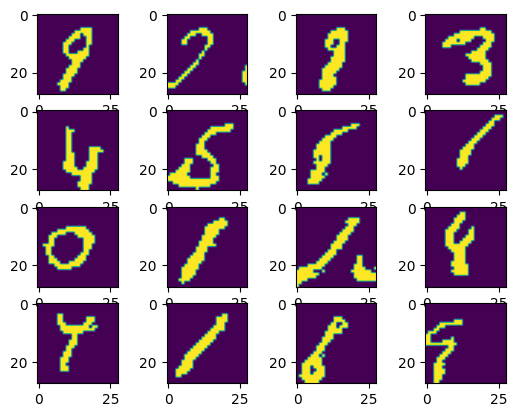

In [ ]:
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(epochs):
    for i, (images, _) in enumerate(trainloader):
        x = images.to(device)
        targets = images.to(device)
        targets = targets.permute(0, 2, 3, 1).view(x.shape[0], input_size[1]*input_size[2],input_size[0])

        # zero the parameter gradients
        optimizer.zero_grad()

        logits = model(x)

        loss = F.binary_cross_entropy_with_logits(logits, targets)
        model.loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch + 1, epochs, i + 1, len(trainloader), loss.item()))
    if epoch in [0, 3, 5, 9, 13, 17, 19]:
      torch.save(model.state_dict, f"/content/rnn_epoch{epoch + 1}.pth")
      sampled_imgs = model.sample(16)
      for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(sampled_imgs[i, :, :, :].permute(1, 2, 0).numpy())
      plt.savefig(f"/content/sampled_img_epoch{epoch+1}.png")

print('Finished Training')
# save the model
torch.save(model.state_dict(), '/content/rnn.pth')

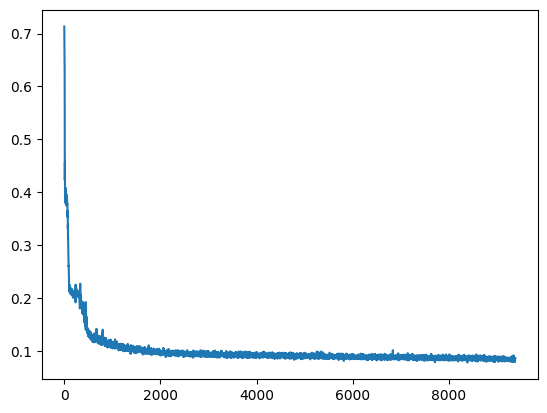

In [ ]:
# plot the loss
plt.plot(model.loss_values)
plt.savefig("/content/loss_function.png")